In [ ]:
!pip -q install networkx ipywidgets

import hashlib
import bisect
import random
from dataclasses import dataclass
from typing import Dict, List, Optional

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import ipywidgets as widgets

In [ ]:
def _u64_hash(s: str) -> int:
    h = hashlib.sha256(s.encode("utf-8")).digest()[:8]
    return int.from_bytes(h, byteorder="big", signed=False)

@dataclass(frozen=True)
class StorageNode:
    node_id: str

class ConsistentHashRing:
    def __init__(self, vnodes_per_node: int = 80):
        self.vnodes_per_node = int(vnodes_per_node)
        self.ring_keys: List[int] = []
        self.ring_map: Dict[int, str] = {}
        self.nodes: Dict[str, StorageNode] = {}

    def _vnode_key(self, node_id: str, v: int) -> int:
        return _u64_hash(f"node:{node_id}#vnode:{v}")

    def add_node(self, node: StorageNode) -> None:
        if node.node_id in self.nodes:
            return
        self.nodes[node.node_id] = node
        for v in range(self.vnodes_per_node):
            k = self._vnode_key(node.node_id, v)
            if k in self.ring_map:
                k = _u64_hash(f"node:{node.node_id}#vnode:{v}#salt:{random.random()}")
            bisect.insort(self.ring_keys, k)
            self.ring_map[k] = node.node_id

    def remove_node(self, node_id: str) -> None:
        if node_id not in self.nodes:
            return
        del self.nodes[node_id]
        to_remove = [k for k, nid in self.ring_map.items() if nid == node_id]
        for k in to_remove:
            del self.ring_map[k]
        self.ring_keys = sorted(self.ring_map.keys())

    def get_node(self, key: str) -> Optional[str]:
        if not self.ring_keys:
            return None
        hk = _u64_hash(f"key:{key}")
        idx = bisect.bisect_left(self.ring_keys, hk)
        if idx == len(self.ring_keys):
            idx = 0
        return self.ring_map[self.ring_keys[idx]]

    def snapshot(self) -> Dict[str, int]:
        counts = {nid: 0 for nid in self.nodes}
        for _, nid in self.ring_map.items():
            counts[nid] = counts.get(nid, 0) + 1
        return dict(sorted(counts.items()))

In [ ]:
class VectorDBSimulator:
    def __init__(self, ring: ConsistentHashRing, dim: int = 256, seed: int = 42):
        self.ring = ring
        self.dim = int(dim)
        self.rng = np.random.default_rng(seed)
        self.vectors: Dict[str, np.ndarray] = {}

    def add_vectors(self, n: int) -> None:
        start = len(self.vectors)
        for i in range(start, start + int(n)):
            vid = f"vec_{i:06d}"
            emb = self.rng.normal(size=(self.dim,)).astype(np.float32)
            emb /= (np.linalg.norm(emb) + 1e-12)
            self.vectors[vid] = emb

    def shard_map(self) -> Dict[str, str]:
        out = {}
        for vid in self.vectors.keys():
            nid = self.ring.get_node(vid)
            out[vid] = nid if nid is not None else "∅"
        return out

    def distribution(self) -> Dict[str, int]:
        dist: Dict[str, int] = {}
        for nid in self.shard_map().values():
            dist[nid] = dist.get(nid, 0) + 1
        return dict(sorted(dist.items()))

    @staticmethod
    def movement_fraction(before: Dict[str, str], after: Dict[str, str]) -> float:
        moved = sum(1 for k in before if before[k] != after[k])
        return moved / max(1, len(before))

In [ ]:
def draw_ring(ring: ConsistentHashRing, dist: Dict[str, int], title: str):
    node_ids = sorted(ring.nodes.keys())
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_title(title)

    if not node_ids:
        plt.text(0.5, 0.5, "Ring is empty", ha="center", va="center")
        plt.axis("off")
        plt.show()
        return

    G = nx.Graph()
    for nid in node_ids:
        G.add_node(nid)
    for i in range(len(node_ids)):
        G.add_edge(node_ids[i], node_ids[(i + 1) % len(node_ids)])

    pos = nx.circular_layout(G)
    vnode_counts = ring.snapshot()
    labels = {
        nid: f"{nid}\nkeys={dist.get(nid,0)}\nvnodes={vnode_counts.get(nid,0)}"
        for nid in node_ids
    }

    nx.draw_networkx_edges(G, pos, alpha=0.4, width=2)
    nx.draw_networkx_nodes(G, pos, node_size=2200)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
    plt.axis("off")
    plt.show()

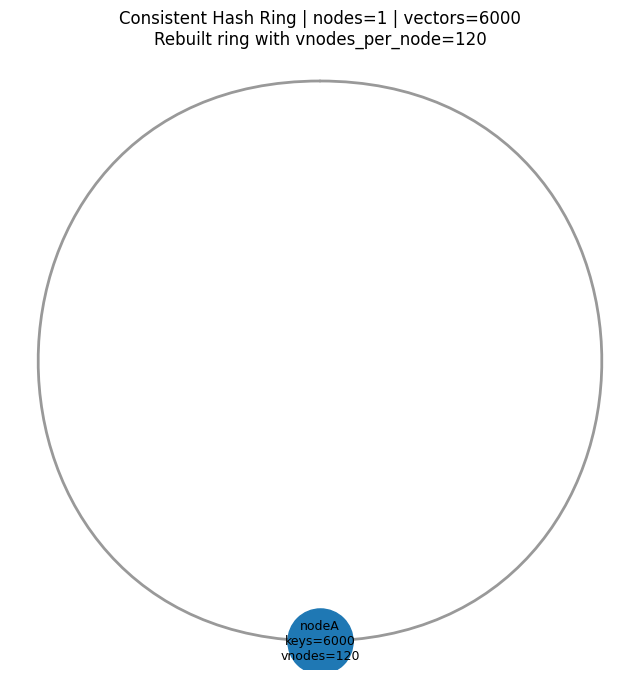

Output()

In [1]:
ring = ConsistentHashRing(vnodes_per_node=80)
sim = VectorDBSimulator(ring)
sim.add_vectors(6000)

node_name = widgets.Text(value="nodeA", description="Node ID:")
add_btn = widgets.Button(description="Add node", button_style="success")
rm_btn = widgets.Button(description="Remove node", button_style="danger")
vnodes_slider = widgets.IntSlider(value=80, min=20, max=300, step=20, description="VNodes/node")
regen_btn = widgets.Button(description="Rebuild ring", button_style="warning")
status = widgets.Output()

def render(msg: str = ""):
    clear_output(wait=True)
    display(widgets.HBox([node_name, add_btn, rm_btn]))
    display(widgets.HBox([vnodes_slider, regen_btn]))
    dist = sim.distribution()
    title = f"Consistent Hash Ring | nodes={len(ring.nodes)} | vectors={len(sim.vectors)}"
    if msg:
        title += f"\n{msg}"
    draw_ring(ring, dist, title)
    with status:
        status.clear_output()
        print("Shard distribution:", dist)
    display(status)

def on_add(_):
    before = sim.shard_map()
    ring.add_node(StorageNode(node_name.value.strip() or f"node{len(ring.nodes)+1}"))
    after = sim.shard_map()
    moved = sim.movement_fraction(before, after)
    render(f"Added node | moved={moved:.3f} (~{moved*100:.1f}%)")

def on_remove(_):
    before = sim.shard_map()
    ring.remove_node(node_name.value.strip())
    after = sim.shard_map()
    moved = sim.movement_fraction(before, after)
    render(f"Removed node | moved={moved:.3f} (~{moved*100:.1f}%)")

def on_regen(_):
    ids = list(ring.nodes.keys())
    new_ring = ConsistentHashRing(vnodes_per_node=int(vnodes_slider.value))
    for nid in ids:
        new_ring.add_node(StorageNode(nid))
    sim.ring = new_ring
    globals()["ring"] = new_ring
    render(f"Rebuilt ring with vnodes_per_node={vnodes_slider.value}")

add_btn.on_click(on_add)
rm_btn.on_click(on_remove)
regen_btn.on_click(on_regen)

render("Add or remove nodes to observe data movement")